# Pinball loss-guided LightGBM

### 1. Load libraries

In [2]:
# General libraries
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np
from numpy import array, hstack
from numpy import asarray

import pickle # load and save data

# Data preparation
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV # time series validation windows
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Plots
%matplotlib inline
import matplotlib.pyplot as plt

# LightGBM - Package
from lightgbm import LGBMRegressor

### 2. Load & prepare data
#### Consumptin data

In [3]:
df_consumption = pd.read_csv("{}/consumption_prepared.csv".format(data_source_folder), sep=",", decimal = ',')
df_consumption['date'] = pd.to_datetime(df_consumption['date']) # change date to date-time var
df_consumption.set_index('date', inplace = True) # create index
df_consumption['consumption'] = df_consumption['consumption'].astype(float) # change consumption values to float

#### Weather data

In [4]:
# Load weather Data
df_weather = pd.read_csv("{}/daily_weather_avg.csv".format(data_source_folder), sep=",", decimal = ',')
df_weather['date'] = pd.to_datetime(df_weather['date'])

#### Add date-time information to weather data

In [5]:
# add date information
def compute_weekend(row):
    if row['weekday'] > 4:
        return True
    else:
        return False

In [6]:
# subset to 2018
df_weather[['temp', 'wind', 'cloud']] = df_weather[['temp', 'wind', 'cloud']].shift(+1) # each day gets informaiton on weather the day before
df_weather_shift = df_weather.iloc[1:, :]

df_weather_rep = DataFrame()
for i in range(3):
    temp = pd.Series(df_weather_shift.iloc[:,1+i])
    rep = temp.repeat(96)
    df_weather_rep[i] = rep
df_weather_rep.columns = ['temp', 'wind', 'cloud']

In [7]:
df_weather_rep['date'] = pd.date_range(start = '2018-01-01 00:00:00', periods = 43680, freq = '15T')
df_weather_rep.set_index('date', inplace=True)

df_weather_rep.loc[:,'month'] = df_weather_rep.index.month
df_weather_rep.loc[:,'day'] = df_weather_rep.index.day
df_weather_rep.loc[:,'hour'] = df_weather_rep.index.hour
df_weather_rep['weekday']= df_weather_rep.index.weekday
df_weather_rep['is_weekend'] = df_weather_rep.apply (lambda row:compute_weekend(row), axis = 1)

# Transform categorical date-time variables
df_weather_rep['month'] = pd.Series(df_weather_rep['month'], dtype="category")
df_weather_rep['day'] = pd.Series(df_weather_rep['day'], dtype="category")
df_weather_rep['hour'] = pd.Series(df_weather_rep['hour'], dtype="category")
df_weather_rep['weekday'] = pd.Series(df_weather_rep['weekday'], dtype="category")
df_weather_rep['is_weekend'] = pd.Series(df_weather_rep['is_weekend'], dtype="category")

df_weather_rep.drop(df_weather_rep.columns[[6]], axis=1, inplace=True) # 6 position weekday column

### 3. Train-test split

In [8]:
# train data: year 2018/ test data: year 2019 90 days

# split into standard days (atm 20%)
train_cons, test_cons = df_consumption.iloc[:35040,:], df_consumption.iloc[35040:, :]
train_weath, test_weath = df_weather_rep.iloc[:35040,:], df_weather_rep.iloc[35040:, :]

### 4. Data transformation
#### Train data

In [9]:
# convert series to supervised learning
def series_to_supervised(data, data1, n_in=72, n_out=48, dropnan=True):
    
    df_weather_time = DataFrame(data1)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('consumption(t-{})'.format(i)) for j in range(n_vars)]
    
    weather_cols = list(train_weath)
    for i in range(df_weather_time.shape[1]):
        cols.append(df_weather_time.iloc[:,i])
        names += [weather_cols[i]]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('consumption(t)') for j in range(n_vars)]
        else:
            names += [('consumption(t+{})'.format(i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Define forecasting approach
n_in = 192
n_out = 96
n_vars = 6

# load dataset
cons = train_cons.values
date_time = train_weath.iloc[:, 3:7]
weather = train_weath.iloc[:, 0:3]

encoder1 = LabelEncoder()
#date_time = encoder1.fit_transform(date_time)
date_time_scaled = df_weather_rep.iloc[:, 3:7].apply(encoder1.fit_transform).values
date_time_scaled_train = date_time_scaled[:35040]
date_time_scaled_test =date_time_scaled[35040:]

# integer encode direction
date_time = date_time.astype('float32')

# normalize features
scaler1 = MinMaxScaler()
scaled_consumption = scaler1.fit_transform(cons)
scaler2 = MinMaxScaler()
scaled_weather = scaler2.fit_transform(weather)
weather_all = hstack((scaled_weather, date_time_scaled_train)) # combine transformed data

# frame as supervised learning
reframed_train = series_to_supervised(scaled_consumption, weather_all, n_in, n_out)

#print(list(reframed_train.head(1)))

In [10]:
# Split transformed train set into train and validation set

#Input numbers
n_out = 96
cons_hist = 192
other_vars = 7
n_in = cons_hist+other_vars

# split into train and test sets
values_train = reframed_train.values
train, val = values_train[:-6950, :], values_train[-6950:, :]
# split into input and outputs
train_X, train_y = train[:, :-n_out], train[:, -n_out:]
val_X, val_y = val[:, :-n_out], val[:, -n_out:]

print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

# Combined train set
full_train_X, full_train_y = values_train[:, :-n_out], values_train[:, -n_out:]

(27803, 199) (27803, 96) (6950, 199) (6950, 96)


#### Test data

In [11]:
# Test set

# Define forecasting approach
n_in = 192
n_out = 96
n_vars = 6

# load dataset
cons_test = test_cons
weather_test_s = test_weath.iloc[:, 0:3].values

# normalize features
scaled_consumption = scaler1.transform(cons_test)
scaled_weather = scaler2.transform(weather_test_s)
scaled = hstack((scaled_weather, date_time_scaled_test))

# frame as supervised learning
reframed_test = series_to_supervised(scaled_consumption, scaled, n_in, n_out)

#print(reframed_test.head(1))

In [12]:
#Input numbers
n_out = 96
cons_hist = 192
other_vars = 7
n_in = cons_hist+other_vars

# split into train and test sets
values_test = reframed_test.values

# split into input and outputs
test_X, test_y = values_test[:, :-n_out], values_test[:, -n_out:]

print(test_X.shape, test_y.shape)

(8353, 199) (8353, 96)


### 5. Model setup

#### Create loss function

In [13]:
def quantile_loss(y_true, y_pred, q):
    return np.max([q*(y_true - y_pred), (1-q)*(y_pred-y_true)], axis=0)

#### Define goal of prediction approach

In [14]:
# Define the quantiles to predict as decimal
quantiles = [.2, .4, .6, .8]
n_steps_ahead = 96

### Hyperparameter tuning - working
-> for each forecast horizon and quantile individually

In [15]:
# Preparation
validation_window_size = n_steps_ahead
tsp = TimeSeriesSplit(n_splits = validation_window_size)

In [16]:
number_of_features_lagged = 6
quantile = 0.2

model_params = list()
for hour in range(n_steps_ahead):

    hyperparams = {'objective': 'quantile', 'metric': 'quantile', 'boosting_type': 'gbdt', 'learning_rate': 0.1}
    variable_params = {'max_depth': [3, 5], 'num_leaves': [5, 10, 15],'n_estimators': [50, 100], 'subsample':[0.4, 0.6], 'learning_rate': [0.01, 0.1]}
    xgb1 = LGBMRegressor(**hyperparams, alpha=quantile)
    model = GridSearchCV(
        xgb1,
        cv = tsp,
        param_grid = variable_params)

    model.fit(train_X, train_y[:,hour])
    print("Best Accuracy:{}".format(model.best_score_))
    print(model.best_params_)
    model_params.append(model.best_score_)
    
with open("C:/Users/alexl/Desktop/daily/pickle_lstm_best_model_params.text", "wb") as fp:   #Pickling
    pickle.dump(model_params, fp)

KeyboardInterrupt: 

### 5. Final model fitting and predicting
- fit model to combined train and validation data

In [17]:
# Hyperparameters of model
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 6,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'subsample': 0.7,
    'boosting_type': 'gbdt',
}

In [18]:
def lgbm_final_fit(trainx, trainy, testx, testy, hour, quant):
    predictions = list()
    actuals = list()

    final_lgbm = LGBMRegressor(**params, alpha=quant)
    final_lgbm.fit(trainx, trainy[:, hour])

    #history = [x for x in train]
    for i in range(len(testx)):
        yhat = final_lgbm.predict(asarray([testx[i,:]]))[0]
        predictions.append(yhat)
        actuals.append(testy[i, hour])
        #print('>actual=%.1f, predicted=%.1f' % (test_y[i, h], yhat))
    pinball_loss = quantile_loss(testy[:, h], predictions, q = quant).mean()

    return pinball_loss, actuals, predictions, final_lgbm

In [20]:
# Train models
quantiles = [.2, .4, .6, .8]
models = list()

df_losses_per_quantile = DataFrame()
l_preds_per_quant = list()
l_actuals_per_quant = list()

for quantile in quantiles:
    losses_per_hour = list()
    predict = DataFrame()
    actual = DataFrame()
    #preds = list()
    for h in range(96):
        loss, test, predictions, model= lgbm_final_fit(full_train_X, full_train_y, test_X, test_y, h, quant = quantile)
        actual['pred_hour_{}_actual'.format(h+1)] = pd.Series(test)
        predict['pred_hour_{}_quant_{}'.format(h+1,str(quantile)[-1])] = pd.Series(predictions)
        print('Pinball loss quantile {} hour {}: {}'.format(quantile, h+1, loss))
        losses_per_hour.append(loss)
        models.append(model)
    df_losses_per_quantile['loss_q{}'.format(str(quantile)[-1])] = losses_per_hour
    l_preds_per_quant.append(predict)
    l_actuals_per_quant.append(actual)

Pinball loss quantile 0.2 hour 1: 0.002868176254252173
Pinball loss quantile 0.2 hour 2: 0.004169655970982844
Pinball loss quantile 0.2 hour 3: 0.005199382252769026
Pinball loss quantile 0.2 hour 4: 0.006045757124357763
Pinball loss quantile 0.2 hour 5: 0.006778686913174301
Pinball loss quantile 0.2 hour 6: 0.007430593914816876
Pinball loss quantile 0.2 hour 7: 0.008102450656837215
Pinball loss quantile 0.2 hour 8: 0.00859208750100966
Pinball loss quantile 0.2 hour 9: 0.008871713604966235
Pinball loss quantile 0.2 hour 10: 0.009380564575847484
Pinball loss quantile 0.2 hour 11: 0.009689188237186326
Pinball loss quantile 0.2 hour 12: 0.010152084479556869
Pinball loss quantile 0.2 hour 13: 0.01041021120826952
Pinball loss quantile 0.2 hour 14: 0.010637382502599652
Pinball loss quantile 0.2 hour 15: 0.01126395831682201
Pinball loss quantile 0.2 hour 16: 0.011329701641670815
Pinball loss quantile 0.2 hour 17: 0.011518173947068661
Pinball loss quantile 0.2 hour 18: 0.012047752225328709
Pinb

Pinball loss quantile 0.4 hour 53: 0.027577140976017715
Pinball loss quantile 0.4 hour 54: 0.028138814874009842
Pinball loss quantile 0.4 hour 55: 0.027873316883092778
Pinball loss quantile 0.4 hour 56: 0.028725571894296243
Pinball loss quantile 0.4 hour 57: 0.028862612155102253
Pinball loss quantile 0.4 hour 58: 0.02867603876861514
Pinball loss quantile 0.4 hour 59: 0.02936139007431981
Pinball loss quantile 0.4 hour 60: 0.02870376504266464
Pinball loss quantile 0.4 hour 61: 0.029592164701530848
Pinball loss quantile 0.4 hour 62: 0.030367289835012516
Pinball loss quantile 0.4 hour 63: 0.030396896947860894
Pinball loss quantile 0.4 hour 64: 0.030152818585491074
Pinball loss quantile 0.4 hour 65: 0.03049618473950594
Pinball loss quantile 0.4 hour 66: 0.03041591265394278
Pinball loss quantile 0.4 hour 67: 0.030548437462580035
Pinball loss quantile 0.4 hour 68: 0.030525612477907544
Pinball loss quantile 0.4 hour 69: 0.03053611567497543
Pinball loss quantile 0.4 hour 70: 0.03120450977446118

Pinball loss quantile 0.8 hour 9: 0.009315896370814173
Pinball loss quantile 0.8 hour 10: 0.009472579269814313
Pinball loss quantile 0.8 hour 11: 0.009857506558892547
Pinball loss quantile 0.8 hour 12: 0.010158869375565625
Pinball loss quantile 0.8 hour 13: 0.010363451719883546
Pinball loss quantile 0.8 hour 14: 0.01075345140935611
Pinball loss quantile 0.8 hour 15: 0.010931864974769237
Pinball loss quantile 0.8 hour 16: 0.011281129166467905
Pinball loss quantile 0.8 hour 17: 0.01148352959592543
Pinball loss quantile 0.8 hour 18: 0.011868749033004817
Pinball loss quantile 0.8 hour 19: 0.011785019417743164
Pinball loss quantile 0.8 hour 20: 0.012021563646825892
Pinball loss quantile 0.8 hour 21: 0.012253420367902893
Pinball loss quantile 0.8 hour 22: 0.012894859395340696
Pinball loss quantile 0.8 hour 23: 0.012558218546389577
Pinball loss quantile 0.8 hour 24: 0.013073992517748849
Pinball loss quantile 0.8 hour 25: 0.013014967481242815
Pinball loss quantile 0.8 hour 26: 0.01308890303410

#### Load saved predictions

In [ ]:
#with open("/content/drive/MyDrive/Colab Notebooks/Predictions/lightgbm_preds_{}.txt".format(date), "rb") as fp:   # Unpickling
#    preds_loaded_reg = pickle.load(fp)
#
#with open("/content/drive/MyDrive/Colab Notebooks/Predictions/lightgbm_actuals_{}.txt".format(date), "rb") as fp:   # Unpickling
#    actuals_loaded_reg = pickle.load(fp)

#### Inverse scale predictions and calculate accuracies

In [22]:
# apply inverse scaling to data
def extract_predictions(df_actuals, df_predictions1):
    steps = 96
    df_predictions = DataFrame()
    l_actuals_inverse = list()
    l_predictions_inverse = list()
    for quantile in range(len(quantiles)):
        df_inv_preds = DataFrame()
        df_inv_acts = DataFrame()
        for step in range(95):
            inv_yhat = scaler1.inverse_transform(np.array(df_predictions1[quantile].iloc[:, step]).reshape(-1, 1))
            df_inv_preds['pred_step_{}_quant_{}'.format(step, quantiles[quantile])] = pd.Series(inv_yhat.reshape(inv_yhat.shape[0]))

            inv_act = scaler1.inverse_transform(np.array(df_actuals[quantile].iloc[:, step]).reshape(-1, 1))
            df_inv_acts['actual_step_{}_quant_{}'.format(step, quantiles[quantile])] = pd.Series(inv_act.reshape(inv_act.shape[0]))
        l_predictions_inverse.append(df_inv_preds)
        l_actuals_inverse.append(df_inv_acts) 
        
    return l_actuals_inverse, l_predictions_inverse

def get_accuracies(df_actuals1, df_predictions1, quantiles):
    df_loss_scores = DataFrame()
    for quantile in range(len(quantiles)):
        loss_scores = list()
        for step in range(95):
            ploss = np.mean(quantile_loss(df_actuals1[quantile].iloc[:,step], df_predictions1[0].iloc[:,step], quantiles[quantile]))
            loss_scores.append(ploss)
        df_loss_scores['scores_quant_{}'.format(str(quantiles[quantile]))] = pd.Series(loss_scores)
    
    return df_loss_scores

#### Inverse scale predictions and get accuracies

In [70]:
df_acts, df_preds = extract_predictions(l_actuals_per_quant, l_preds_per_quant)
df_loss_all = get_accuracies(df_acts, df_preds, quantiles)

In [24]:
print('Average pinball loss scores pre quantile: ')
print(df_loss_all.mean())

Average pinball loss scores pre quantile: 
scores_quant_0.2    0.308928
scores_quant_0.4    0.455814
scores_quant_0.6    0.602700
scores_quant_0.8    0.749587
dtype: float64


In [25]:
avergage_loss_lgbm = round(df_loss_all.mean().mean(), 4)
print('The overall average loss score of the LGBM model is: {}'.format(avergage_loss_lgbm))

The overall average loss score of the LGBM model is: 0.5293


In [26]:
# Loss scores 2 hours ahead
l_2 = df_loss_all.iloc[7,:]
print('Scores per quantile:')
print(l_2)

# Average loss score 2 hours ahead
print('Average: ',l_2.mean())

Scores per quantile:
scores_quant_0.2    0.143092
scores_quant_0.4    0.213841
scores_quant_0.6    0.284590
scores_quant_0.8    0.355339
Name: 7, dtype: float64
Average:  0.24921577566709896


In [27]:
# Loss scores 8 hours ahead
l_8 = df_loss_all.iloc[31,:]
print('Scores per quantile:')
print(l_8)

# Average loss score 8 hours ahead
print('Average: ',l_8.mean())

Scores per quantile:
scores_quant_0.2    0.258509
scores_quant_0.4    0.387039
scores_quant_0.6    0.515569
scores_quant_0.8    0.644098
Name: 31, dtype: float64
Average:  0.45130385812507917


In [29]:
# Loss scores 14 hours ahead
l_14 = df_loss_all.iloc[51,:]
print('Scores per quantile:')
print(l_14)

# Average loss score 14 hours ahead
print('Average: ',l_14.mean())

Scores per quantile:
scores_quant_0.2    0.360373
scores_quant_0.4    0.526284
scores_quant_0.6    0.692195
scores_quant_0.8    0.858106
Name: 51, dtype: float64
Average:  0.6092393771452238


In [30]:
# Loss scores 20 hours ahead
l_20 = df_loss_all.iloc[79,:]
print('Scores per quantile:')
print(l_20)

# Average loss score 20 hours ahead
print('Average: ',l_20.mean())

Scores per quantile:
scores_quant_0.2    0.416856
scores_quant_0.4    0.606259
scores_quant_0.6    0.795661
scores_quant_0.8    0.985064
Name: 79, dtype: float64
Average:  0.7009599003241451


### Compute feature importance for predictions 2 hours ahead 

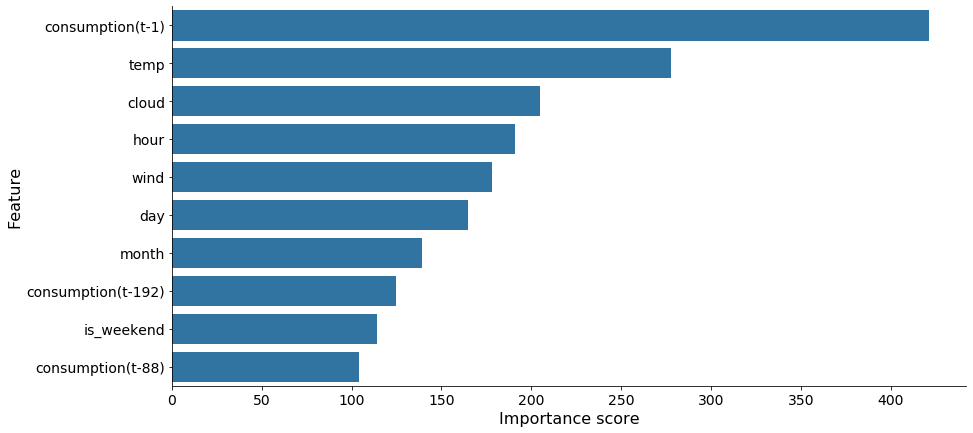

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(models[8].feature_importances_,reframed_test.columns[:-n_out]))[-10:], columns=['Value','Feature'])

plt.figure(figsize=(13, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), color = 'tab:blue')
plt.tight_layout()
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xlabel("Importance score", size=16)
plt.ylabel("Feature", size=16)
sns.despine()

#### Save prediction results

In [71]:
# Accuracies
df_losses_per_quantile.to_csv("{}/LGBM_losses.csv".format(data_source_folder))

# Predictions
with open("{}/lightgbm_preds_final.txt".format(data_source_folder), "wb") as fp:   #Pickling
    pickle.dump(df_preds, fp)
    
with open("{}/lightgbm_actuals_final.txt".format(data_source_folder), "wb") as fp:   #Pickling
    pickle.dump(df_acts, fp)